In [17]:
import os
import numpy as np
import pandas as pd

import random

# visulization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
digits = np.loadtxt('./NN_digits_train.csv', delimiter=',', dtype=int, skiprows=1)

In [5]:
classes = digits[:, 0]
pixels = digits[:, 1:]

In [22]:
pixels = pixels / 255

---
exploring data

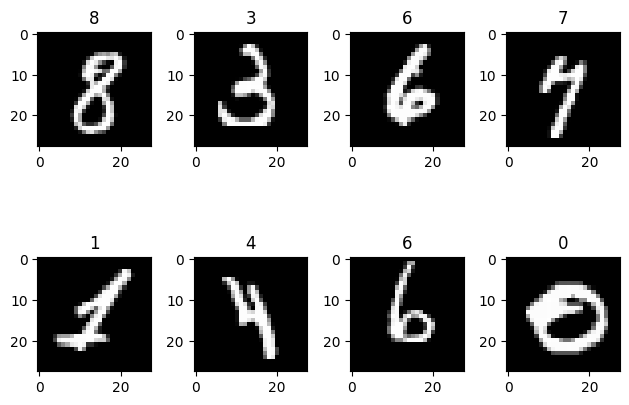

In [91]:
fig, axs = plt.subplots(nrows=2, ncols=4)

for i in range(8):
    idx = random.randint(0, len(pixels)-1)
    axs[i//4, i%4].set_title(classes[idx])
    axs[i//4, i%4].imshow(pixels[idx].reshape(28, 28), cmap='gray')
plt.tight_layout()
plt.show() 

---
how convolutions work

In [24]:
from scipy.ndimage import convolve

In [55]:
i = 33357
img = pixels[i].reshape(28, 28)

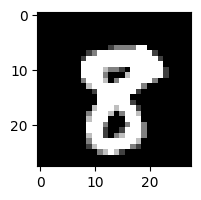

In [56]:
plt.figure(figsize=(2,2))
plt.imshow(img, cmap='gray')

In [57]:
def convolve2d(image, kernel, stride=1, padding=0):
    image = np.pad(image, [(padding, padding), (padding, padding)], mode='constant', constant_values=0)

    kernel_height, kernel_width = kernel.shape
    padded_height, padded_width = image.shape

    output_height = (padded_height - kernel_height) // stride + 1
    output_width = (padded_width - kernel_width) // stride + 1

    new_image = np.zeros((output_height, output_width)).astype(np.float32)

    for y in range(0, output_height):
        for x in range(0, output_width):
            new_image[y][x] = np.sum(image[y * stride:y * stride + kernel_height, x * stride:x * stride + kernel_width] * kernel).astype(np.float32)
    return new_image

In [71]:
KERNEL_SIZE = (5, 5)
NUM = 25

In [84]:
# vertical kernels
kernel0 = np.zeros(KERNEL_SIZE)
kernel0[:, 0] = 1
kernel0 /= NUM

kernel1 = np.zeros(KERNEL_SIZE)
kernel1[:, KERNEL_SIZE[0]//2] = 1
kernel1 /= NUM

kernel2 = np.zeros(KERNEL_SIZE)
kernel2[:, KERNEL_SIZE[0]-1] = 1
kernel2 /= NUM

In [85]:
# vertical kernels
kernel3 = np.zeros(KERNEL_SIZE)
kernel3[0, :] = 1
kernel3 /= NUM

kernel4 = np.zeros(KERNEL_SIZE)
kernel4[KERNEL_SIZE[0]//2, :] = 1
kernel4 /= NUM

kernel5 = np.zeros(KERNEL_SIZE)
kernel5[KERNEL_SIZE[0]-1, :] = 1
kernel5 /= NUM

In [86]:
# diagonal kernels
kernel6 = np.zeros(KERNEL_SIZE)
for i in range(KERNEL_SIZE[0]):
    kernel6[i, i] = 1
kernel6 /= NUM

kernel7 = np.zeros(KERNEL_SIZE)
for i in range(KERNEL_SIZE[0]):
    kernel7[i, KERNEL_SIZE[0] - 1 - i] = 1
kernel7 /= NUM

kernel8 = np.zeros(KERNEL_SIZE)
for i in range(KERNEL_SIZE[0]):
    kernel8[i, i] = 1
    kernel8[i, KERNEL_SIZE[0] - 1 - i] = 1
kernel8 /= NUM

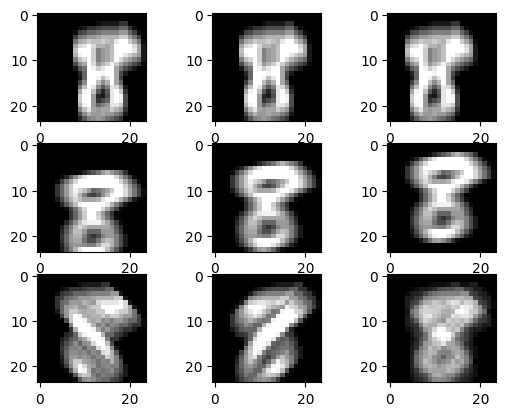

In [87]:
fig, axs = plt.subplots(ncols=3, nrows=3)

axs[0][0].imshow(convolve2d(img, kernel0), cmap='gray')
axs[0][1].imshow(convolve2d(img, kernel1), cmap='gray')
axs[0][2].imshow(convolve2d(img, kernel2), cmap='gray')

axs[1][0].imshow(convolve2d(img, kernel3), cmap='gray')
axs[1][1].imshow(convolve2d(img, kernel4), cmap='gray')
axs[1][2].imshow(convolve2d(img, kernel5), cmap='gray')

axs[2][0].imshow(convolve2d(img, kernel6), cmap='gray')
axs[2][1].imshow(convolve2d(img, kernel7), cmap='gray')
axs[2][2].imshow(convolve2d(img, kernel8), cmap='gray')

In [88]:
def maxpool2d(image, size, stride=1, padding=0):
    image = np.pad(image, [(padding, padding), (padding, padding)], mode='constant', constant_values=0)

    padded_height, padded_width = image.shape

    output_height = (padded_height - size) // stride + 1
    output_width = (padded_width - size) // stride + 1

    new_image = np.zeros((output_height, output_width)).astype(np.float32)

    for y in range(0, output_height):
        for x in range(0, output_width):
            new_image[y][x] = np.max(image[y * stride:y * stride + size, x * stride:x * stride + size])
    return new_image


def avgpool2d(image, size, stride=1, padding=0):
    image = np.pad(image, [(padding, padding), (padding, padding)], mode='constant', constant_values=0)

    padded_height, padded_width = image.shape

    output_height = (padded_height - size) // stride + 1
    output_width = (padded_width - size) // stride + 1

    new_image = np.zeros((output_height, output_width)).astype(np.float32)

    for y in range(0, output_height):
        for x in range(0, output_width):
            new_image[y][x] = np.mean(image[y * stride:y * stride + size, x * stride:x * stride + size])
    return new_image

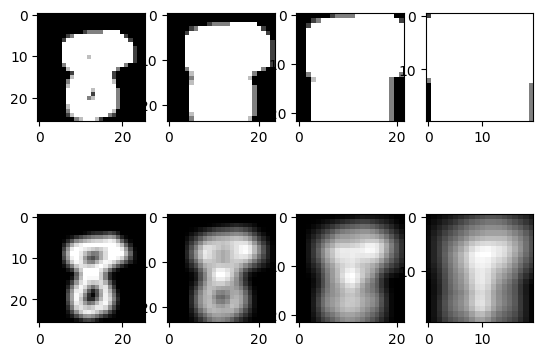

In [89]:
fig, axs = plt.subplots(nrows=2, ncols=4)
kernel_sizes = [3, 5, 7, 9]

for i, size in enumerate(kernel_sizes):
    axs[0][i].imshow(maxpool2d(img, size), cmap='gray')

for i, size in enumerate(kernel_sizes):
    axs[1][i].imshow(avgpool2d(img, size), cmap='gray')

plt.show()

In [92]:
# ring kernel
# ring = np.zeros((5, 5))

---
# Torch introduction

In [95]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor

from sklearn.model_selection import train_test_split

RANDOM_SEED = 20240419

In [96]:
pics_2d = pixels.reshape((pixels.shape[0], int(np.sqrt(pixels.shape[1])), int(np.sqrt(pixels.shape[1]))))

In [99]:
X_train, X_test, y_train, y_test = train_test_split(pixels, classes, test_size=0.2,
                                                    random_state=RANDOM_SEED)

In [105]:
class DigitDtaset(Dataset):
    def __init__(self, X, y) -> None:
        assert X.shape[0] == y.size

        n = int(np.sqrt(X.shape[1]))

        self.X = torch.from_numpy(X).view(X.shape[0], n, n)
        self.y = y

    def __len__ (self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        y = self.Y[i]
        vec = np.zeros(10)
        vec[y] = 1.
        return self.X[index], torch.from_numpy(vec)

In [106]:
train_data = DigitDtaset(X_train, y_train)
test_data = DigitDtaset(X_test, y_test)

In [107]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [108]:
class NeuralNetwork(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.layer1 = nn.Conv2d(1, 10, 9)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.layer2 = nn.MaxPool2d(10, 10, 5)
        self.pool2 = nn.MaxPool2d(3, 1)
        self.layer3 = nn.Linear(160, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU(x)
        x = self.pool1(x)
        x = self.layer2(x)
        x = nn.ReLU(x)
        x = self.pool2(x)
        x = nn.Flatten(x)
        x = self.layer3(x)
        x = nn.Softmax(x)
        return x

In [109]:
model = NeuralNetwork()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()

In [110]:
for idx, (x, y) in enumerate(train_loader):
    optimizer.zero_grad()
    predicted = model(x)
    loss = loss_fn(predicted, y)
    loss.backward()
    optimizer.step()
    print(loss.item())

AttributeError: 'DigitDtaset' object has no attribute 'Y'